# Plotting

This notebook contains numerous plots with different purposes.

In [1]:
import os
import numpy as np
from scipy.stats import kendalltau
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
import torchvision.transforms as transforms

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
sns.set_style('ticks')

from helpers import *
from visualization import *
from redundancy import *
from relevance import *
from preprocessing import *
from datasets import *
from models import *

from config import *
from config_models import *

torch.manual_seed(42)
cuda = torch.device('cuda:1')

### Globals

In [2]:
DATASET_ID_TRAIN = DATASET_IDS[0]
DATASET_ID_TEST = DATASET_IDS[1]
BASE_DATA_DIR = '/scratch/korunosk/data'
EMBEDDINGS_DIR = os.path.join(BASE_DATA_DIR, 'BERT_sent')

### Models

In [3]:
models = [
    NeuralNetRougeRegModel.load('neural_net_rouge_reg_model.pt', CONFIG_MODELS['NeuralNetRougeRegModel']).to(device=cuda),
    NeuralNetSinkhornPRModel.load('neural_net_sinkhorn_pr_model.pt', CONFIG_MODELS['NeuralNetSinkhornPRModel']).to(device=cuda),
    NeuralNetScoringPRModel.load('neural_net_scoring_pr_model.pt', CONFIG_MODELS['NeuralNetScoringPRModel']).to(device=cuda),
]

## Plotting topics distribution using documents only

In [159]:
dataset = {}

for topic_id in TOPIC_IDS[DATASET_ID_TRAIN]:
    topic = load_data(os.path.join(EMBEDDINGS_DIR, DATASET_ID_TRAIN), topic_id, encoded=True)
    document_embs, summary_embs, indices, pyr_scores, summ_ids = extract(topic)
    document_pts, summary_pts = project_pca(np.concatenate((document_embs, summary_embs)), len(document_embs))
    dataset[topic_id] = {
        'documents': document_pts,
        'reference_summaries': summary_pts[indices[-4][0]:indices[-1][1]]
    }

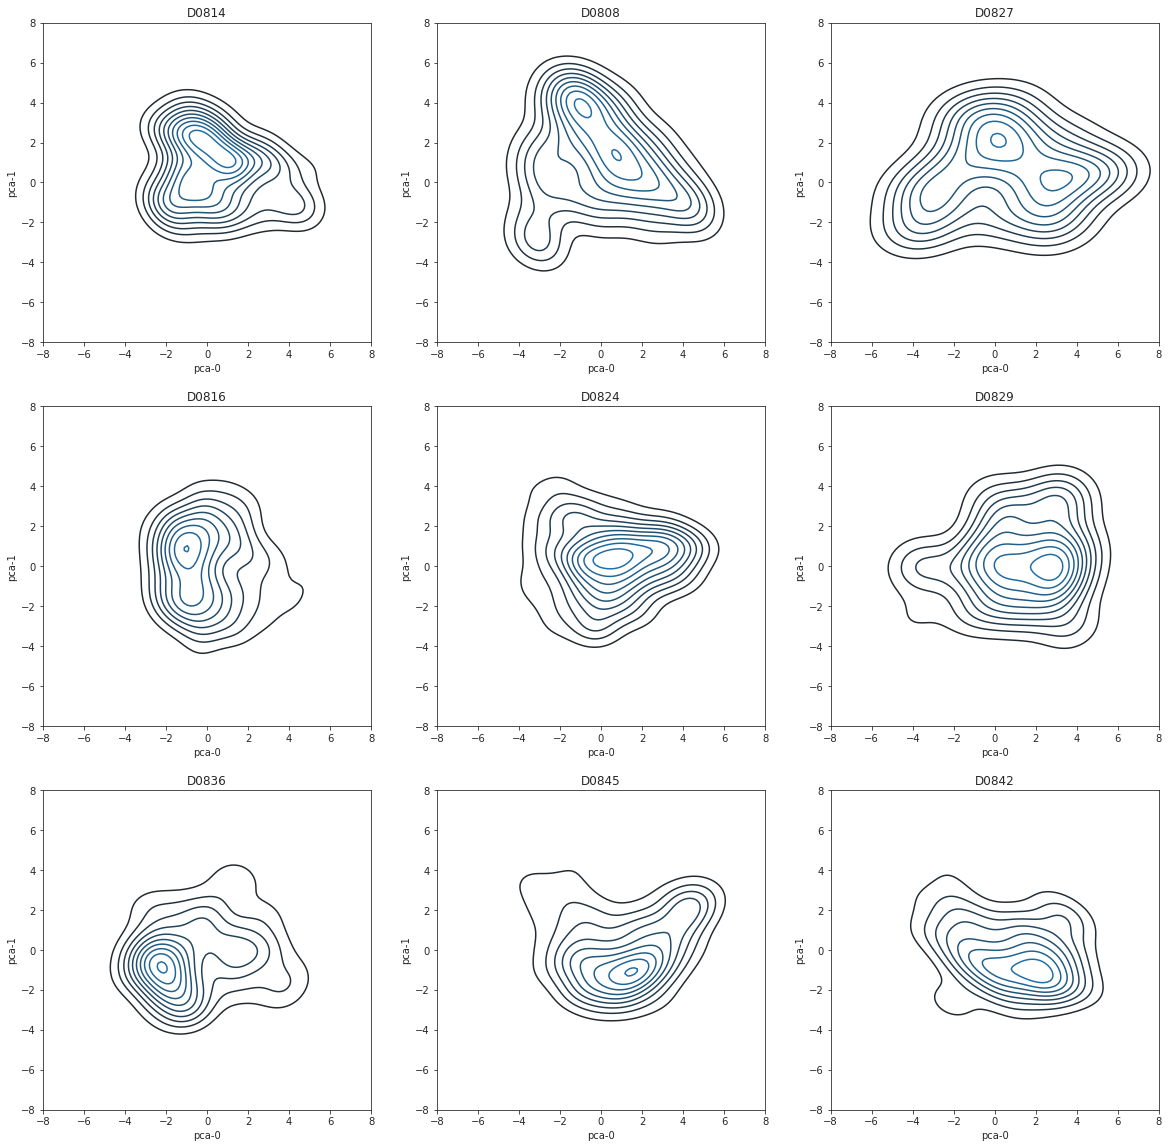

In [160]:
topic_ids = [
    'D0814','D0808','D0827',
    'D0816','D0824','D0829',
    'D0836','D0845','D0842'
]

fig = plt.figure(figsize=(20,20))
for i in range(9):
    topic_id = topic_ids[i]
    ax = fig.add_subplot(3,3,i+1)
    sns.kdeplot(dataset[topic_id]['documents'][:,0],
                dataset[topic_id]['documents'][:,1],
                ax=ax)
    ax.set_title(topic_id)
    ax.set_xlabel('pca-0')
    ax.set_ylabel('pca-1')
    ax.set_xlim(-8,8)
    ax.set_ylim(-8,8)
plt.show()
fig.savefig(os.path.join(PLOTS_DIR, f'topics_distribution_1.png'), dpi=fig.dpi, bbox_inches='tight')

## Plotting topics distribution using documents and reference summaries

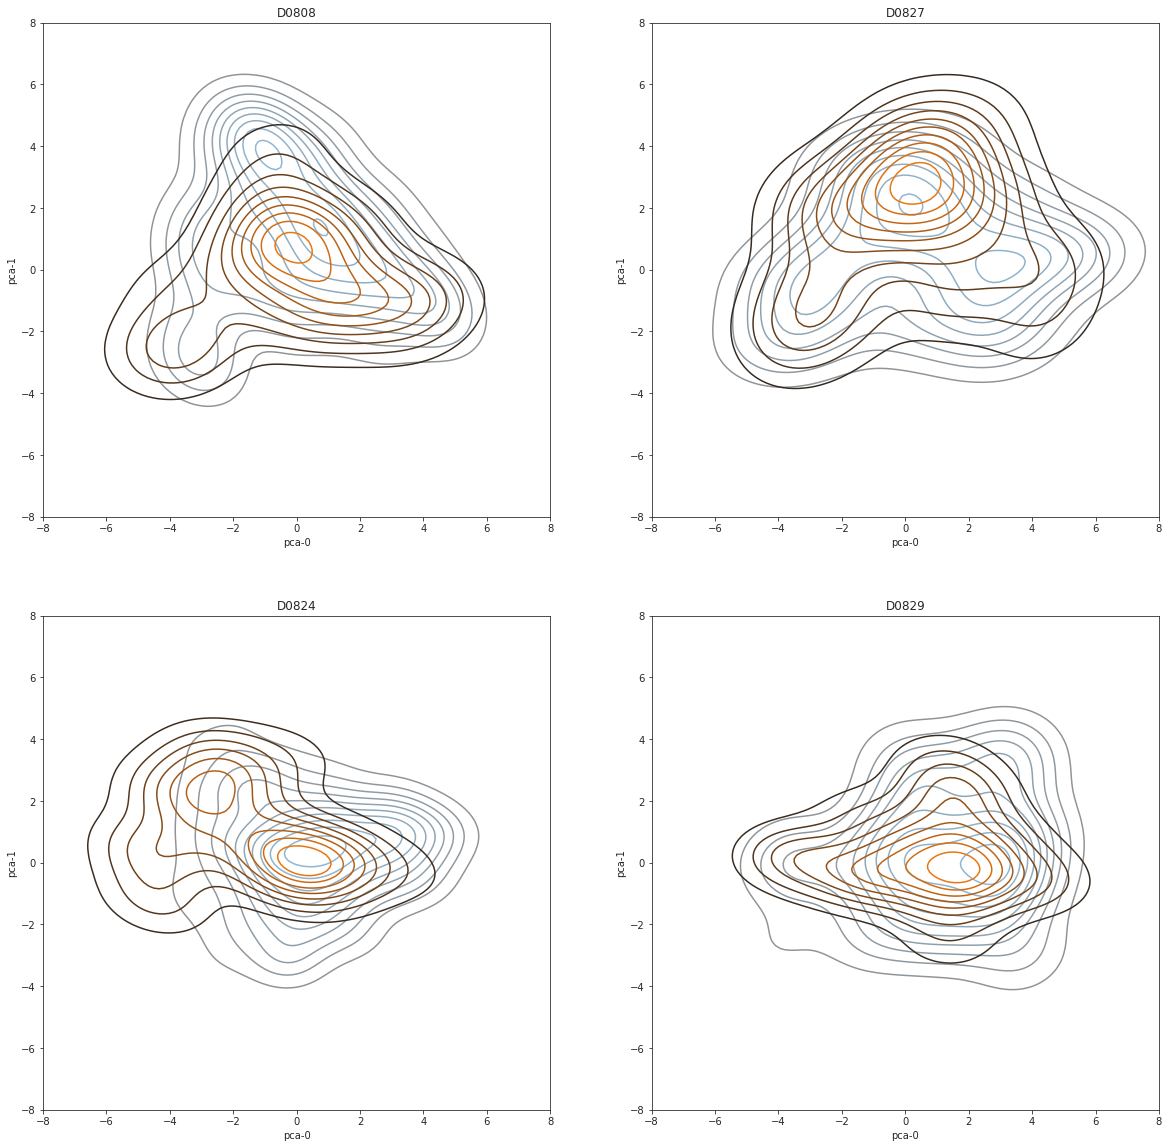

In [161]:
topic_ids = [
    'D0808','D0827',
    'D0824','D0829'
]

fig = plt.figure(figsize=(20,20))
for i in range(4):
    topic_id = topic_ids[i]
    ax = fig.add_subplot(2,2,i+1)
    sns.kdeplot(dataset[topic_id]['documents'][:,0],
                dataset[topic_id]['documents'][:,1],
                alpha=0.5,
                ax=ax)
    sns.kdeplot(dataset[topic_id]['reference_summaries'][:,0],
                dataset[topic_id]['reference_summaries'][:,1],
                alpha=1,
                ax=ax)
    ax.set_title(topic_id)
    ax.set_xlabel('pca-0')
    ax.set_ylabel('pca-1')
    ax.set_xlim(-8,8)
    ax.set_ylim(-8,8)
plt.show()
fig.savefig(os.path.join(PLOTS_DIR, f'topics_distribution_2.png'), dpi=fig.dpi, bbox_inches='tight')

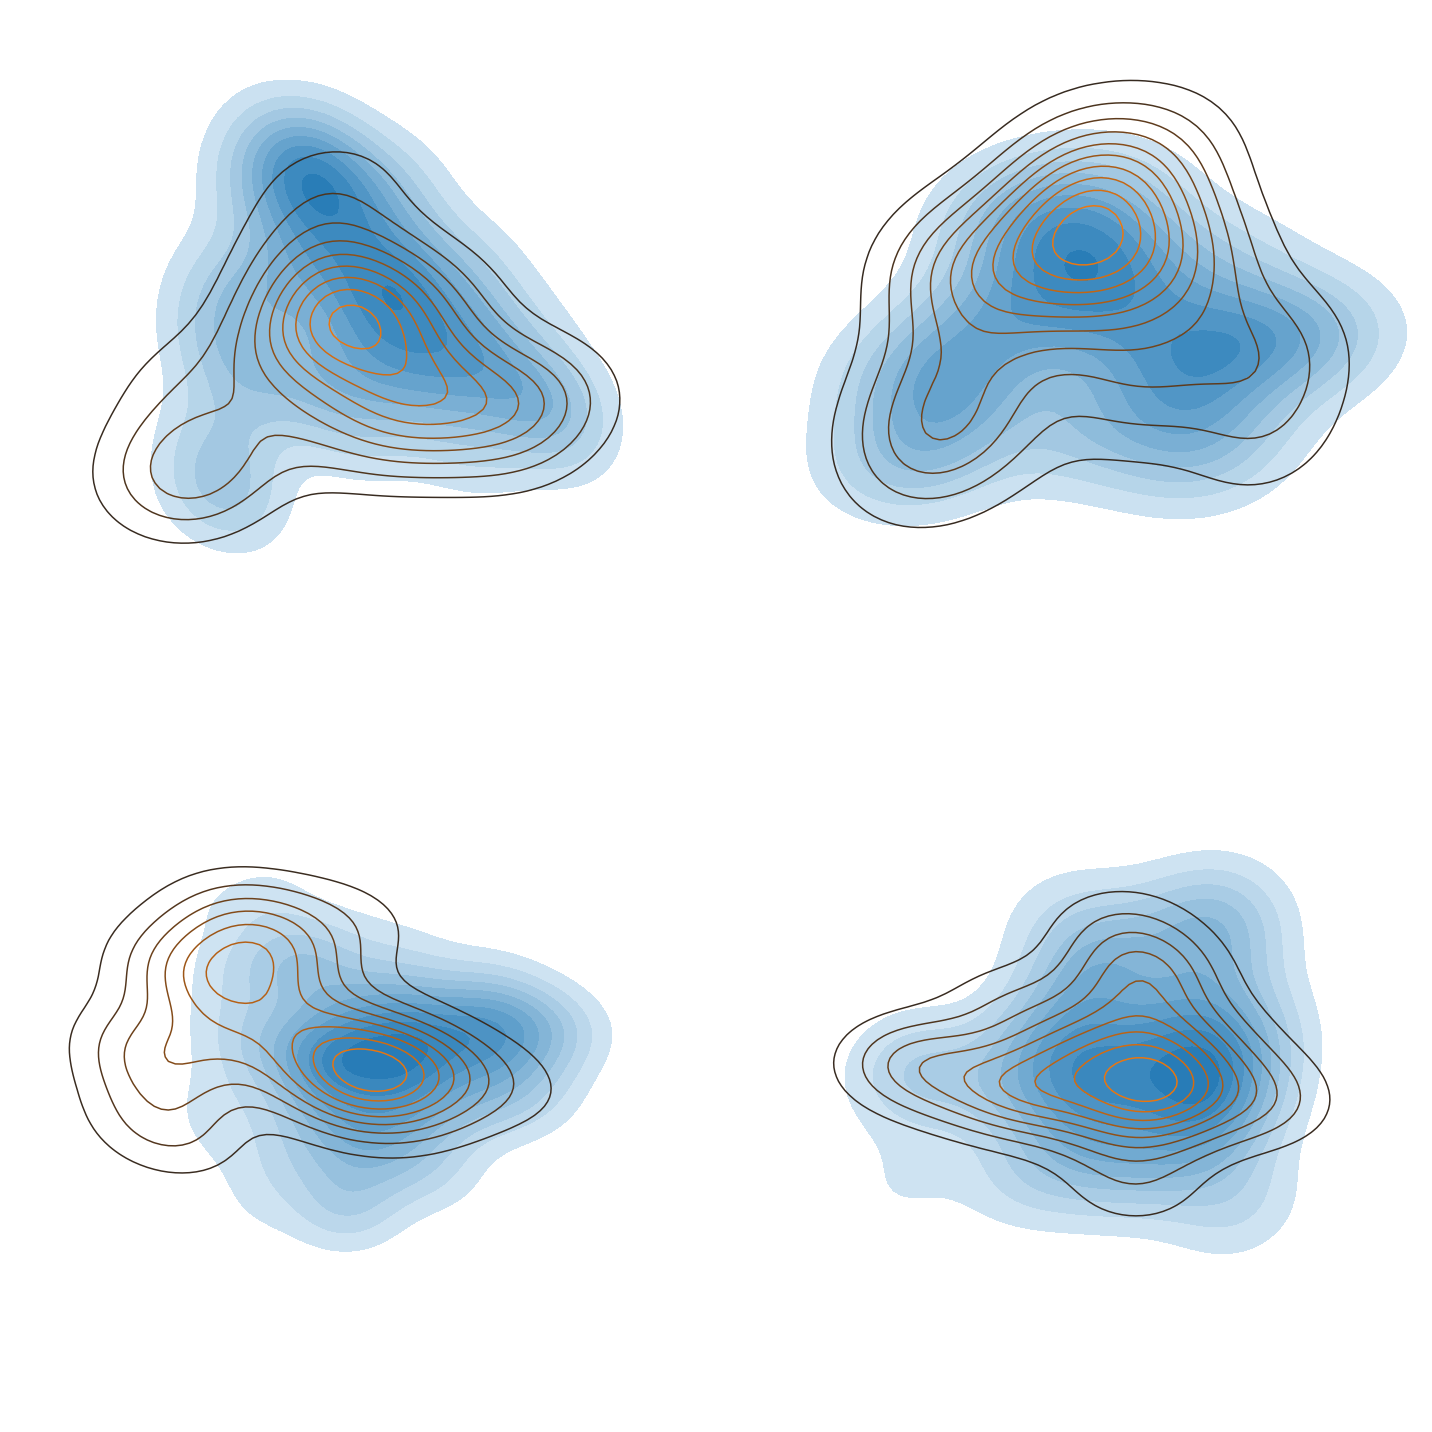

In [166]:
topic_ids = [
    'D0808','D0827',
    'D0824','D0829'
]

fig = plt.figure(figsize=(20,20))
for i in range(4):
    topic_id = topic_ids[i]
    ax = fig.add_subplot(2,2,i+1)
    sns.kdeplot(dataset[topic_id]['documents'][:,0],
                dataset[topic_id]['documents'][:,1],
                alpha=1,
                shade=True,
                shade_lowest=False,
                ax=ax)
    sns.kdeplot(dataset[topic_id]['reference_summaries'][:,0],
                dataset[topic_id]['reference_summaries'][:,1],
                alpha=1,
                ax=ax)
    ax.set_xlim(-8,8)
    ax.set_ylim(-8,8)
    ax.axis('off')
plt.tight_layout()
plt.show()
fig.savefig(os.path.join(PLOTS_DIR, f'topics_distribution_2_presentation.png'), dpi=fig.dpi, bbox_inches='tight')

## Analysis of distributions' mean, rotation and spread change

In [106]:
mean = []
rotation = []
spread = []

for topic_id in TOPIC_IDS[DATASET_ID_TRAIN]:
    pts1 = dataset[topic_id]['documents']
    pts2 = dataset[topic_id]['reference_summaries']
    
    pca1 = PCA(n_components=2).fit(pts1)
    pca2 = PCA(n_components=2).fit(pts2)
    
    v  = pca2.mean_ - pca1.mean_
    vn = np.linalg.norm(v)
    
    R  = pca1.components_.T @ pca2.components_
    th = np.degrees(np.arccos(R[0,0]))
    
    s1 = np.linalg.det(pts1.T @ pts1)
    s2 = np.linalg.det(pts2.T @ pts2)
    r  = s2 / s1
    
    mean.append(vn)
    rotation.append(th)
    spread.append(r)
    
    print('*** {} ***'.format(topic_id))
    print('Mean     {:4.2f}'.format(mean[-1]))
    print('Rotation {:4.2f}'.format(rotation[-1]))
    print('Spread   {:4.2f}'.format(spread[-1]))

print('{:.2f} {:.2f} {:.2f}'.format(np.mean(mean), np.mean(rotation), np.mean(spread)))

*** D0841 ***
Mean     3.49
Rotation 81.96
Spread   0.02
*** D0804 ***
Mean     2.19
Rotation 59.51
Spread   0.01
*** D0802 ***
Mean     1.61
Rotation 21.41
Spread   0.01
*** D0809 ***
Mean     0.61
Rotation 11.90
Spread   0.01
*** D0819 ***
Mean     1.53
Rotation 6.36
Spread   0.04
*** D0825 ***
Mean     0.94
Rotation 148.74
Spread   0.00
*** D0828 ***
Mean     1.15
Rotation 31.61
Spread   0.01
*** D0826 ***
Mean     1.57
Rotation 15.60
Spread   0.00
*** D0843 ***
Mean     0.59
Rotation 169.19
Spread   0.03
*** D0829 ***
Mean     0.52
Rotation 19.09
Spread   0.08
*** D0813 ***
Mean     2.64
Rotation 28.36
Spread   0.01
*** D0807 ***
Mean     2.70
Rotation 165.39
Spread   0.02
*** D0812 ***
Mean     2.53
Rotation 50.31
Spread   0.01
*** D0820 ***
Mean     0.22
Rotation 66.63
Spread   0.05
*** D0835 ***
Mean     0.85
Rotation 26.27
Spread   0.00
*** D0823 ***
Mean     1.69
Rotation 163.71
Spread   0.03
*** D0847 ***
Mean     1.64
Rotation 37.86
Spread   0.04
*** D0848 ***
Mean     1.10


## Plotting 3D projection of BERT word-level embeddings

In [147]:
EMBEDDINGS_DIR = os.path.join(BASE_DATA_DIR, 'BERT_word')

dataset = {}

for topic_id in TOPIC_IDS[DATASET_ID_TRAIN]:
    topic = load_data(os.path.join(EMBEDDINGS_DIR, DATASET_ID_TRAIN), topic_id, encoded=True)
    document_embs, summary_embs, indices, pyr_scores, summ_ids = extract(topic)
    document_pts, summary_pts = project_pca(np.concatenate((document_embs, summary_embs)), len(document_embs), 3)
    dataset[topic_id] = {
        'documents': document_pts,
        'reference_summaries': summary_pts[indices[-4][0]:indices[-1][1]]
    }

EMBEDDINGS_DIR = os.path.join(BASE_DATA_DIR, 'BERT_sent')

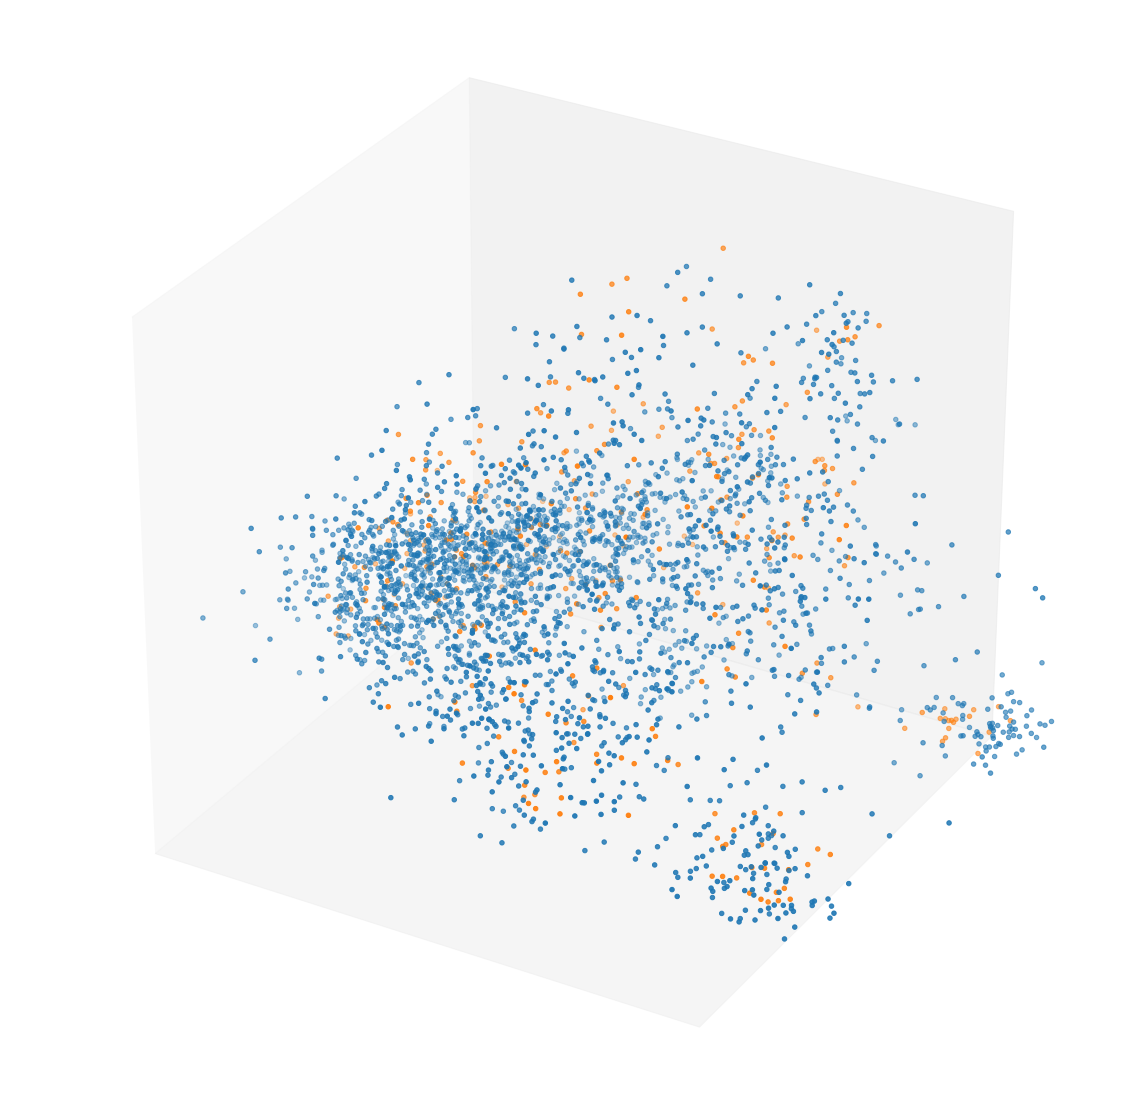

In [158]:
topic_ids = [
    'D0808','D0827',
    'D0824','D0829'
]

fig = plt.figure(figsize=(20,20))
topic_id = topic_ids[2]
ax = fig.add_subplot(111,projection='3d')
ax.scatter(dataset[topic_id]['documents'][:,0],
           dataset[topic_id]['documents'][:,1],
           dataset[topic_id]['documents'][:,2])
ax.scatter(dataset[topic_id]['reference_summaries'][:,0],
           dataset[topic_id]['reference_summaries'][:,1],
           dataset[topic_id]['reference_summaries'][:,2])
ax.set_xlim(-8,8)
ax.set_ylim(-8,8)
ax.set_xticklabels([])
ax.set_yticklabels([])
ax.set_zticklabels([])
ax.set_xticks([])
ax.set_yticks([])
ax.set_zticks([])
ax.w_xaxis.line.set_color((1.0, 1.0, 1.0, 0.0))
ax.w_yaxis.line.set_color((1.0, 1.0, 1.0, 0.0))
ax.w_zaxis.line.set_color((1.0, 1.0, 1.0, 0.0))
plt.show()
fig.savefig(os.path.join(PLOTS_DIR, f'embeddings_presentation.png'), dpi=fig.dpi, bbox_inches='tight')

## Models correlation

D0841
D0804
D0802
D0809
D0819
D0825
D0828
D0826
D0843
D0829
D0813
D0807
D0812
D0820
D0835
D0823
D0847
D0848
D0810
D0822
D0845
D0844
D0839
D0814
D0824
D0821
D0827
D0846
D0818
D0834
D0805
D0817
D0831
D0815
D0836
D0806
D0808
D0837
D0803
D0830
D0838
D0840
D0842
D0832
D0816
D0801
D0833
D0811
D0841
D0804
D0802
D0809
D0819
D0825
D0828
D0826
D0843
D0829
D0813
D0807
D0812
D0820
D0835
D0823
D0847
D0848
D0810
D0822
D0845
D0844
D0839
D0814
D0824
D0821
D0827
D0846
D0818
D0834
D0805
D0817
D0831
D0815
D0836
D0806
D0808
D0837
D0803
D0830
D0838
D0840
D0842
D0832
D0816
D0801
D0833
D0811
D0841
D0804
D0802
D0809
D0819
D0825
D0828
D0826
D0843
D0829
D0813
D0807
D0812
D0820
D0835
D0823
D0847
D0848
D0810
D0822
D0845
D0844
D0839
D0814
D0824
D0821
D0827
D0846
D0818
D0834
D0805
D0817
D0831
D0815
D0836
D0806
D0808
D0837
D0803
D0830
D0838
D0840
D0842
D0832
D0816
D0801
D0833
D0811


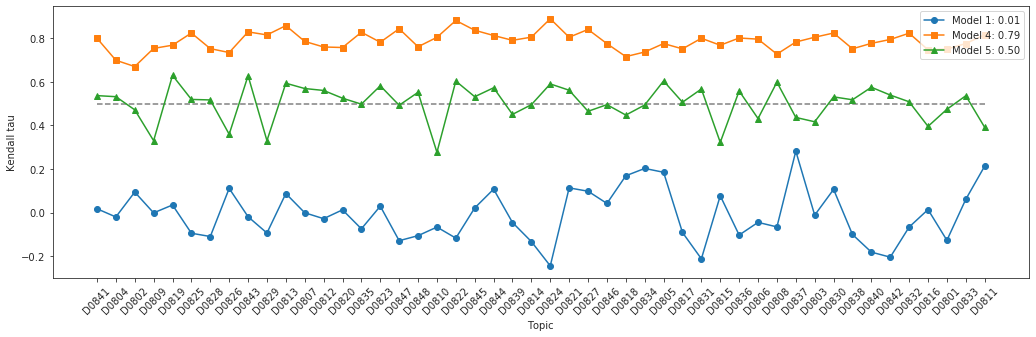

In [14]:
def experiment(model, data):
    document_embs, summary_embs, indices, pyr_scores, summ_ids = data
    document_embs = torch.tensor(document_embs, dtype=torch.float).to(device=cuda)
    metric = lambda i: model.predict(document_embs,
                                     torch.tensor(summary_embs[i[0]:i[1]], dtype=torch.float).to(device=cuda))
    return kendalltau(pyr_scores, np.array([metric(i) for i in indices]))[0]

def execute_experiment(model, experiment):
    scores = []
    with torch.no_grad():
        for topic_id in TOPIC_IDS[DATASET_ID_TRAIN]:
            print(topic_id)
            topic = load_data(os.path.join(EMBEDDINGS_DIR, DATASET_ID_TRAIN), topic_id, encoded=True)
            data = extract(topic)
            scores.append(experiment(model, data))
    return np.array(scores)

scores = [
    execute_experiment(models[0], experiment),
    execute_experiment(models[1], experiment),
    execute_experiment(models[2], experiment),
]

topic_ids = TOPIC_IDS[DATASET_ID_TRAIN]
x = np.arange(len(topic_ids))
fig = plt.figure(figsize=(17.5,5))
ax = fig.add_subplot(1,1,1)
ax.plot(x, scores[0], '-o', label=f'Model 1: {np.mean(-scores[0]):.2f}')
ax.plot(x, -scores[1], '-s', label=f'Model 4: {np.mean(-scores[1]):.2f}')
ax.plot(x, scores[2], '-^', label=f'Model 5: {np.mean(scores[2]):.2f}')
ax.hlines(0.5, x[0], x[-1], linestyle='dashed', color='gray')
ax.set_xticks(x)
ax.set_xticklabels(topic_ids, rotation=45)
ax.set_xlabel('Topic')
ax.set_ylabel('Kendall tau')
ax.legend(loc='upper right')
fig.savefig(os.path.join(PLOTS_DIR, f'models_correlation_2.png'), dpi=fig.dpi, bbox_inches='tight')

## Topic correlation

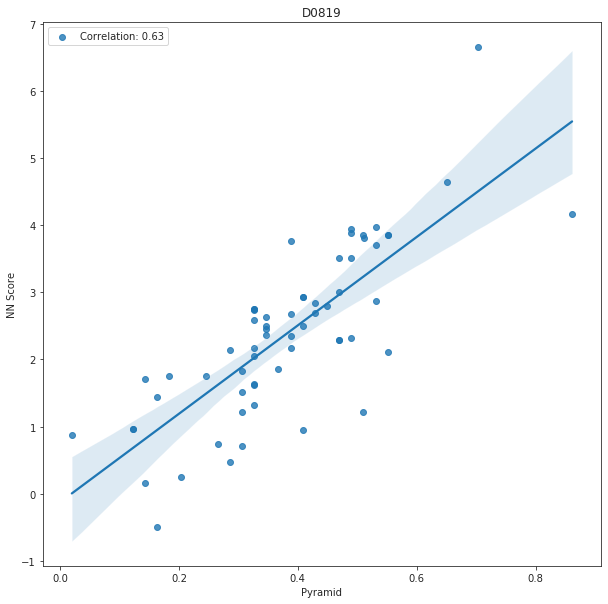

In [7]:
topic = load_data(os.path.join(EMBEDDINGS_DIR, DATASET_ID_TRAIN), TOPIC_IDS[DATASET_ID_TRAIN][4], encoded=True)
document_embs, summary_embs, indices, pyr_scores, _ = extract(topic)

m = np.argsort(-np.array(pyr_scores))

x, y = np.array(pyr_scores)[m], []

d = torch.tensor(document_embs, dtype=torch.float).to(device=cuda)

for i in np.array(indices)[m]:
    s = torch.tensor(summary_embs[i[0]:i[1]], dtype=torch.float).to(device=cuda)
    
    y.append(models[2].predict(d, s).cpu().data.numpy())

fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(1,1,1)
sns.regplot(x, y, label=f'Correlation: {kendalltau(x, y)[0]:.2f}')
ax.set_title(TOPIC_IDS[DATASET_ID_TRAIN][4])
ax.set_xlabel('Pyramid')
ax.set_ylabel('NN Score')
ax.legend(loc='upper left')
plt.show()
fig.savefig(os.path.join(PLOTS_DIR, f'topic_correlation.png'), dpi=fig.dpi, bbox_inches='tight')

## Spaces comparision

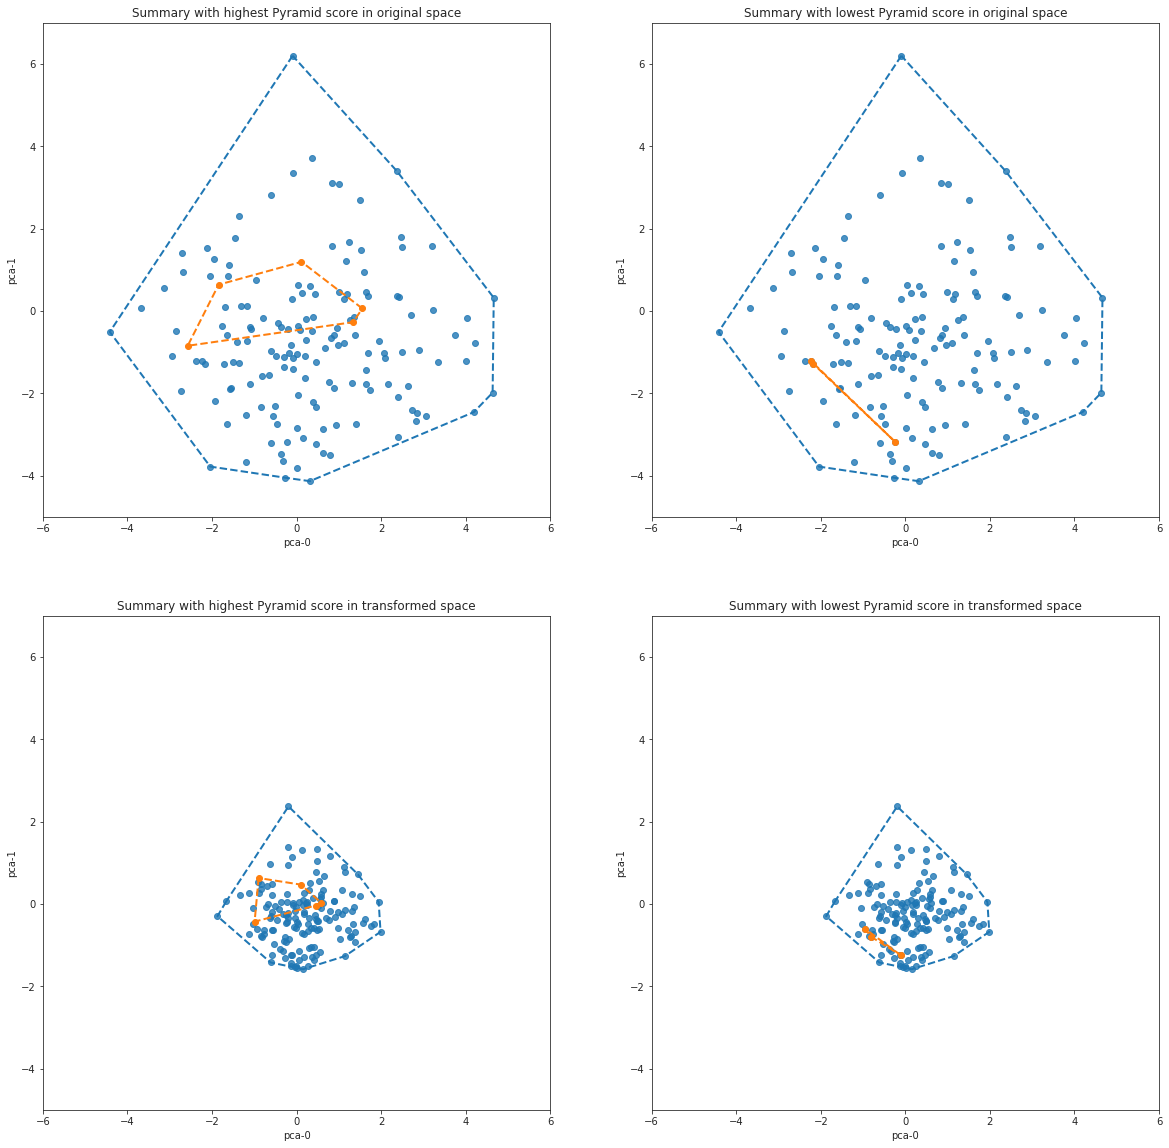

In [132]:
topic = load_data(os.path.join(EMBEDDINGS_DIR, DATASET_ID_TRAIN), TOPIC_IDS[DATASET_ID_TRAIN][4], encoded=True)
document_embs, summary_embs, indices, pyr_scores, _ = extract(topic)

m = np.argsort(-np.array(pyr_scores))

b, w = 0, -1

fig = plt.figure(figsize=(20,20))

document_pts, summary_pts = project_pca(np.concatenate((document_embs, summary_embs)), len(document_embs))

ax1 = fig.add_subplot(2,2,1)
plot_hull(ax1, 'Summary with highest Pyramid score in original space', 'pca', document_pts, summary_pts[indices[m[b]][0]:indices[m[b]][1]])
ax2 = fig.add_subplot(2,2,2)
plot_hull(ax2, 'Summary with lowest Pyramid score in original space', 'pca', document_pts, summary_pts[indices[m[w]][0]:indices[m[w]][1]])

d = torch.tensor(document_embs, dtype=torch.float).to(device=cuda)
s = torch.tensor(summary_embs, dtype=torch.float).to(device=cuda)

document_pts, summary_pts = project_pca(np.concatenate((models[2].transform(d).cpu().data.numpy(),
                                                        models[2].transform(s).cpu().data.numpy())), len(document_embs))

ax3 = fig.add_subplot(2,2,3)
plot_hull(ax3, 'Summary with highest Pyramid score in transformed space', 'pca', document_pts, summary_pts[indices[m[b]][0]:indices[m[b]][1]])
ax4 = fig.add_subplot(2,2,4)
plot_hull(ax4, 'Summary with lowest Pyramid score in transformed space', 'pca', document_pts, summary_pts[indices[m[w]][0]:indices[m[w]][1]])

xlim = [-6,6]
ylim = [-5,7]
ax1.set_xlim(xlim)
ax1.set_ylim(ylim)
ax2.set_xlim(xlim)
ax2.set_ylim(ylim)
ax3.set_xlim(xlim)
ax3.set_ylim(ylim)
ax4.set_xlim(xlim)
ax4.set_ylim(ylim)

plt.show()
fig.savefig(os.path.join(PLOTS_DIR, f'spaces_comparison.png'), dpi=2*fig.dpi, bbox_inches='tight')

## Space transformation

In [114]:
x  = np.random.normal(size=(10000,768))
xt = models[2].transform(
    torch.tensor(x, dtype=torch.float).to(device=cuda)
).cpu().data.numpy()

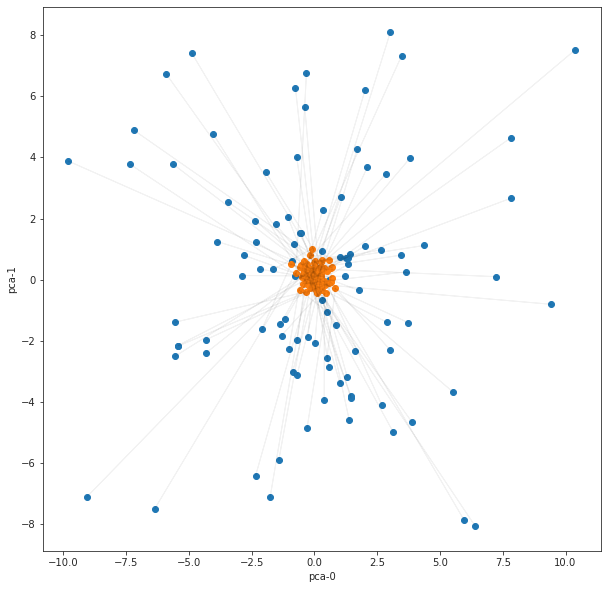

In [115]:
fig = plt.figure(figsize=(10,10))

ax = fig.add_subplot(1,1,1)

pca = PCA(n_components=2, random_state=42)
pts1 = pca.fit_transform(x[:100])
pts2 = pca.transform(xt[:100])

ax.scatter(pts1[:,0], pts1[:,1], alpha=1)
ax.scatter(pts2[:,0], pts2[:,1], alpha=1)
ax.set_title('')
ax.set_xlabel(f'pca-0')
ax.set_ylabel(f'pca-1')

for (x1, y1), (x2, y2) in zip(pts1, pts2):
    ax.arrow(x1, y1, x2-x1, y2-y1, head_width=0, head_length=0, fc='k', ec='k', alpha=0.05)

plt.show()
fig.savefig(os.path.join(PLOTS_DIR, f'space_transformation.png'), dpi=fig.dpi, bbox_inches='tight')

/home/korunosk/.conda/envs/dlab/lib/python3.7/site-packages/ipykernel_launcher.py:5: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  """


Determinant: 0.0000
Eigen value 1: 0.009874749824718245 Eigen vector 1: [0.69897793 0.71514324]
Eigen value 2: 0.004776528144700125 Eigen vector 2: [0.23963238 0.9708637 ]
Singular values: [0.01353556 0.00348467]


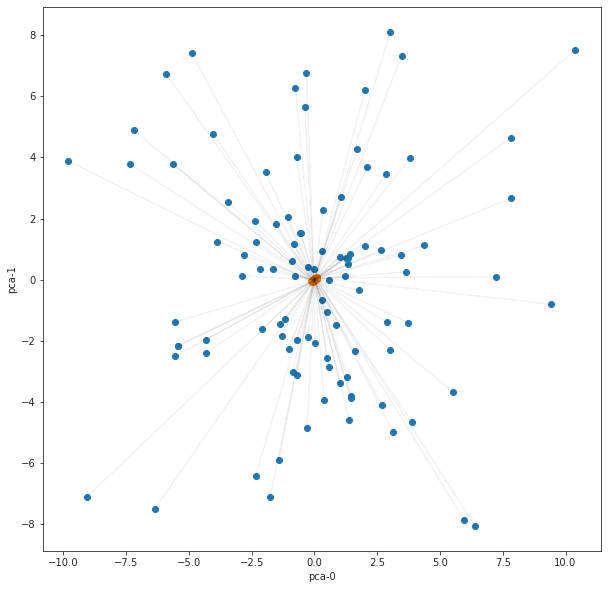

In [116]:
pca = PCA(n_components=2, random_state=42)
pts1 = pca.fit_transform(x)
pts2 = pca.transform(xt)
    
M = np.linalg.lstsq(pts1, pts2)[0]

print(f'Determinant: {np.linalg.det(M):.4f}')
w, v = np.linalg.eig(M)
print(f'Eigen value 1: {w[0]} Eigen vector 1: {v[:,0]}')
print(f'Eigen value 2: {w[1]} Eigen vector 2: {v[:,1]}')
U,S,VT = np.linalg.svd(M)
print(f'Singular values: {S}')

fig = plt.figure(figsize=(10,10))

ax = fig.add_subplot(1,1,1)

pts1 = pca.fit_transform(x[:100])
pts2 = pts1 @ M.T

ax.scatter(pts1[:,0], pts1[:,1], alpha=1)
ax.scatter(pts2[:,0], pts2[:,1], alpha=1)
ax.set_xlabel(f'pca-0')
ax.set_ylabel(f'pca-1')

for (x1, y1), (x2, y2) in zip(pts1, pts2):
    ax.arrow(x1, y1, x2-x1, y2-y1, head_width=0, head_length=0, fc='k', ec='k', alpha=0.05)

plt.show()

In [117]:
pca1 = PCA(random_state=42).fit(x)
pca2 = PCA(random_state=42).fit(xt)

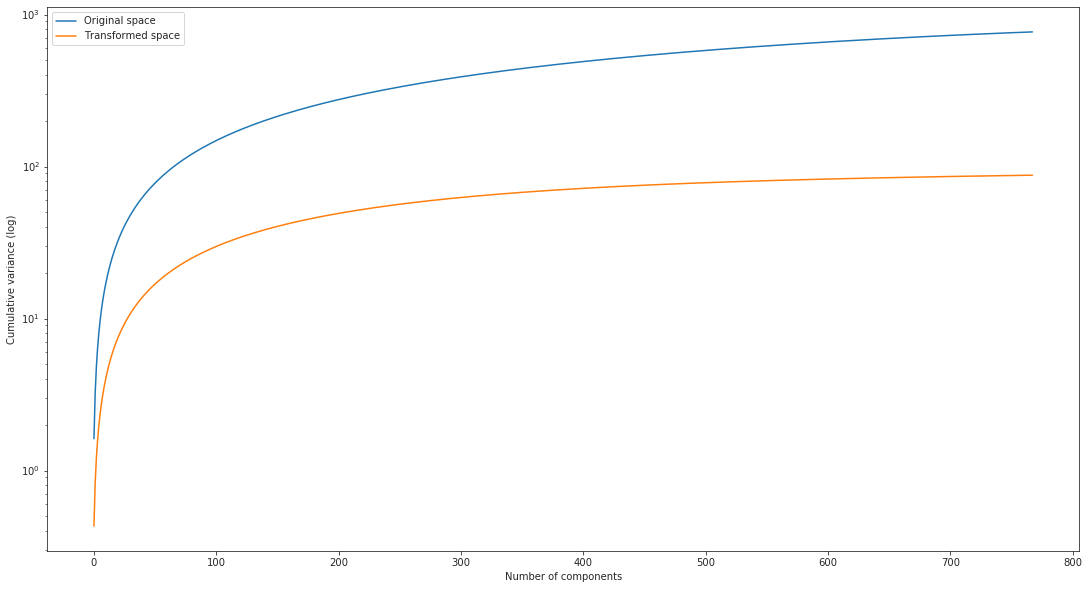

In [120]:
fig = plt.figure(figsize=(1.85*10,10))
ax = fig.add_subplot(1,1,1)
ax.plot(np.cumsum(pca1.explained_variance_), label='Original space')
ax.plot(np.cumsum(pca2.explained_variance_), label='Transformed space')
ax.set_yscale('log')
ax.set_xlabel('Number of components')
ax.set_ylabel('Cumulative variance (log)')
plt.legend()
plt.show()
fig.savefig(os.path.join(PLOTS_DIR, f'cumulative_variance.png'), dpi=fig.dpi, bbox_inches='tight')

In [384]:
print(pca1.explained_variance_ , pca2.explained_variance_)

[1.54292767 1.52838455] [0.41318804 0.37636602]


In [38]:
import scipy as sp
for i in range(3):
    print(1 - sp.spatial.distance.cosine(pca1.components_[i], pca2.components_[i]))

-0.028102230030052633
-0.025817369156270642
0.0012326978179595383
